# Tweeter Bot Detection

## Integrating machine learning to detect bots

Over the past ten plus years, Twitter has explosively evolved into a major communication hub. "Its primary purpose is to connect people and allow people to share their thoughts with a big audience. Twitter can also be a very helpful platform for growing a following and providing your audience with valuable content before they even become customers" [Hubspot](https://blog.hubspot.com/marketing/what-is-twitter). However, not all accounts are geninue users. According to a Twitter SEC filling in 2017, Twitter estimated 8.5% of all users to be bots. To validate the credibility of communication exchanged on the platform, efforts in idnetifying spam bots will help improve user's experience on twitter. 

In this project, we will be using [Cresci-2017](https://botometer.iuni.iu.edu/bot-repository/datasets.html) bot repository datasets to detect bot accounts. We'll begin with exploring traits between geniuine and bot accounts. Then, we will imploy supervised learning models (Logistic Regression, Random Forest, Stoachtic Gradient Boosting) to create a Twitter classifer. Finally, we'll use clustering to identify traits among geniue and spam bot accounts. 

 
### Overview of Data
There are a total of 5 files: 
 * 1 example submission files 
 * 2 transaction files (test and train)
 * 2 identity files (test and train) 
 
 We will be merging train transaction and train identity to gain more information regarding detecting fraud. To keep things simple, we will only be using the training sets. Below is a [description](https://www.kaggle.com/c/ieee-fraud-detection/discussion/101203) of the attributes in each table. 
 
__Transaction Table__

- TransactionDT: timedelta from a given reference datetime (not an actual timestamp)
- TransactionAMT: transaction payment amount in USD
- ProductCD: product code, the product for each transaction
- card1 - card6: payment card information, such as card type, card category, issue bank, country, etc.
- addr: address
- dist: distance
- P_ and (R__) emaildomain: purchaser and recipient email domain
- C1-C14: counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked.
- D1-D15: timedelta, such as days between previous transaction, etc.
- M1-M9: match, such as names on card and address, etc.
- Vxxx: Vesta engineered rich features, including ranking, counting, and other entity relations.
- Categorical Features:
- ProductCD
- card1 - card6
- addr1, addr2
- Pemaildomain Remaildomain
- M1 - M9

__Identity Table__

Variables in this table are identity information – network connection information (IP, ISP, Proxy, etc) and digital signature (UA/browser/os/version, etc) associated with transactions.
They're collected by Vesta’s fraud protection system and digital security partners.
(The field names are masked and pairwise dictionary will not be provided for privacy protection and contract agreement)

Categorical Features:
- DeviceType
- DeviceInfo
- id12 - id38


In [48]:
# Numpy and pandas
import pandas as pd
import numpy as np

#Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

# Statistics tools
import scipy.stats as stats

# Sklearn data clean
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler

# Model selection
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

# Logistic Regression
from sklearn.linear_model import Lasso, LogisticRegression

# KNN Classifer 
from sklearn.neighbors import KNeighborsClassifier

# Decision Trees
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from IPython.display import Image
import pydotplus
import graphviz

# Random Forests 
from sklearn.ensemble import RandomForestClassifier

# SVM
from sklearn.svm import SVC

# Gradient Boost
from xgboost import XGBClassifier

# Evaluate
from sklearn import metrics
from sklearn.metrics import log_loss,accuracy_score, f1_score,roc_auc_score, confusion_matrix, classification_report

# Hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# Datetime
from datetime import datetime

# Import data
import warnings

Let's start by importing tweets and users datasets. 

In [2]:
# Import genuine accounts 
g_tweets = pd.read_csv('/Users/tsawaengsri/Desktop/Data Science Courses/Datasets/cresci-2017.csv/datasets_full.csv/genuine_accounts.csv/tweets.csv')

# Import spam bot accounts
soc_bot1_tweets = pd.read_csv('/Users/tsawaengsri/Desktop/Data Science Courses/Datasets/cresci-2017.csv/datasets_full.csv/social_spambots_1.csv/tweets.csv')
soc_bot2_tweets = pd.read_csv('/Users/tsawaengsri/Desktop/Data Science Courses/Datasets/cresci-2017.csv/datasets_full.csv/social_spambots_2.csv/tweets.csv')
soc_bot3_tweets = pd.read_csv('/Users/tsawaengsri/Desktop/Data Science Courses/Datasets/cresci-2017.csv/datasets_full.csv/social_spambots_3.csv/tweets.csv')


/Users/tsawaengsri/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/tsawaengsri/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/tsawaengsri/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (7,10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
print('Genuine tweets')
print(g_tweets.shape)

print('---------------')

print('Spam bot tweets')
print(soc_bot1_tweets.shape)
print(soc_bot2_tweets.shape)
print(soc_bot3_tweets.shape)

Genuine tweets
(2839362, 25)
---------------
Spam bot tweets
(1610034, 25)
(428542, 25)
(1418557, 25)


In [4]:
# Import genuine accounts 
g_users = pd.read_csv('/Users/tsawaengsri/Desktop/Data Science Courses/Datasets/cresci-2017.csv/datasets_full.csv/genuine_accounts.csv/users.csv')

# Import spam bot accounts
soc_bot1_users = pd.read_csv('/Users/tsawaengsri/Desktop/Data Science Courses/Datasets/cresci-2017.csv/datasets_full.csv/social_spambots_1.csv/users.csv')
soc_bot2_users = pd.read_csv('/Users/tsawaengsri/Desktop/Data Science Courses/Datasets/cresci-2017.csv/datasets_full.csv/social_spambots_2.csv/users.csv')
soc_bot3_users = pd.read_csv('/Users/tsawaengsri/Desktop/Data Science Courses/Datasets/cresci-2017.csv/datasets_full.csv/social_spambots_3.csv/users.csv')


In [5]:
print('Genuine users')
print(g_users.shape)

print('---------------')

print('Spam bot users')
print(soc_bot1_users.shape)
print(soc_bot2_users.shape)
print(soc_bot3_users.shape)

Genuine users
(3474, 42)
---------------
Spam bot users
(991, 41)
(3457, 40)
(464, 41)


## Merging datasets
The transaction training file lacks identity information on each transaction, so we will merge the training identity and transaction files on TransactionID. Since each observation has a unique transaction ID, we will do a 1 to 1 join. We will be performing a left join since our focus remains on the transaction table.

Below, we can see that the row length for train transaction and identity are not equal. It was noted that Vesta was unable to obtain all identity information so we will continue with the merge table for now.

In [6]:
b_tweets = pd.concat([soc_bot1_tweets,soc_bot2_tweets,soc_bot3_tweets], ignore_index=True, sort=False)

In [7]:
# Create tweet class, 1 for bot and 0 for genuine tweets
b_tweets['class'] = 1
g_tweets['class'] = 0

In [8]:
# Concatenate df
tweets = pd.concat([b_tweets,g_tweets], ignore_index=True, sort=False)

# Randomly shuffle df 
tweets = tweets.reindex(np.random.permutation(tweets.index))

In [9]:
tweets.shape

(6296495, 26)

In [10]:
tweets.head()

,id,text,source,user_id,truncated,in_reply_to_status_id,in_reply_to_user_id,in_reply_to_screen_name,retweeted_status_id,geo,...,retweeted,possibly_sensitive,num_hashtags,num_urls,num_mentions,created_at,timestamp,crawled_at,updated,class
5100500,589144017444700161,Everything Emily http://t.co/6dhsg6P8sD,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",2.210092e+09,NaN,0.000000e+00,0.0,NaN,0.0,NaN,...,NaN,NaN,0.0,0.0,0.0,Fri Apr 17 19:10:54 +0000 2015,2015-04-17 21:10:54,2015-05-01 14:05:39,2015-05-01 14:05:39,0
4003296,509830721054466048,@AhmadKKotb if you mean it in a friendly way..,"<a href=""http://twitter.com/download/iphone"" r...",4.997373e+08,NaN,5.098305e+17,173659825.0,AhmadKKotb,0.0,NaN,...,NaN,NaN,0.0,0.0,1.0,Wed Sep 10 22:28:10 +0000 2014,2014-09-11 00:28:10,2015-05-01 13:19:53,2015-05-01 13:19:53,0
3347346,526702310979022848,Great Introduction to Uriah Heep http://t.co/...,"<a href=""http://tweetadder.com"" rel=""nofollow""...",9.386146e+08,NaN,0.000000e+00,0.0,NaN,0.0,NaN,...,NaN,NaN,0.0,1.0,0.0,Mon Oct 27 11:49:51 +0000 2014,2014-10-27 12:49:51,2014-11-13 06:16:45,2014-11-13 06:16:45,1
1441968,403063192764821504,"""Se non amo, non sono niente"". Jean Racine","<a href=""http://www.benedettalacci.it"" rel=""no...",1.273206e+09,NaN,0.000000e+00,0.0,NaN,0.0,NaN,...,NaN,NaN,0.0,0.0,0.0,Wed Nov 20 07:32:08 +0000 2013,2013-11-20 08:32:08,2014-11-13 19:06:15,2014-11-13 19:06:15,1
2814629,509041558327681024,It wasnt a mission to be a rock star. It wasnt...,"<a href=""http://tweetadder.com"" rel=""nofollow""...",5.224195e+08,NaN,0.000000e+00,0.0,NaN,0.0,NaN,...,NaN,NaN,0.0,0.0,0.0,Mon Sep 08 18:12:19 +0000 2014,2014-09-08 20:12:19,2014-11-13 03:20:37,2014-11-13 03:20:37,1


In [11]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6296495 entries, 5100500 to 1967553
Data columns (total 26 columns):
id                         object
text                       object
source                     object
user_id                    float64
truncated                  float64
in_reply_to_status_id      float64
in_reply_to_user_id        float64
in_reply_to_screen_name    object
retweeted_status_id        float64
geo                        float64
place                      object
contributors               float64
retweet_count              float64
reply_count                float64
favorite_count             float64
favorited                  float64
retweeted                  float64
possibly_sensitive         float64
num_hashtags               float64
num_urls                   float64
num_mentions               float64
created_at                 object
timestamp                  object
crawled_at                 object
updated                    object
class          

Now, let's do the same for the users datasets. First, we will drop test columns in g_users, soc_bot1_users and soc_bot3_users so that we can have even numbers of columns. 

In [12]:
g_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3474 entries, 0 to 3473
Data columns (total 42 columns):
id                                    3474 non-null int64
name                                  3473 non-null object
screen_name                           3474 non-null object
statuses_count                        3474 non-null int64
followers_count                       3474 non-null int64
friends_count                         3474 non-null int64
favourites_count                      3474 non-null int64
listed_count                          3474 non-null int64
url                                   1266 non-null object
lang                                  3474 non-null object
time_zone                             2475 non-null object
location                              2365 non-null object
default_profile                       1032 non-null float64
default_profile_image                 13 non-null float64
geo_enabled                           2155 non-null float64
profile_image

In [13]:
soc_bot1_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 991 entries, 0 to 990
Data columns (total 41 columns):
id                                    991 non-null int64
name                                  991 non-null object
screen_name                           991 non-null object
statuses_count                        991 non-null int64
followers_count                       991 non-null int64
friends_count                         991 non-null int64
favourites_count                      991 non-null int64
listed_count                          991 non-null int64
url                                   22 non-null object
lang                                  991 non-null object
time_zone                             903 non-null object
location                              745 non-null object
default_profile                       145 non-null float64
default_profile_image                 1 non-null float64
geo_enabled                           18 non-null float64
profile_image_url               

In [14]:
soc_bot2_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3457 entries, 0 to 3456
Data columns (total 40 columns):
id                                    3457 non-null int64
name                                  3457 non-null object
screen_name                           3457 non-null object
statuses_count                        3457 non-null int64
followers_count                       3457 non-null int64
friends_count                         3457 non-null int64
favourites_count                      3457 non-null int64
listed_count                          3457 non-null int64
url                                   10 non-null object
lang                                  3457 non-null object
time_zone                             14 non-null object
location                              13 non-null object
default_profile                       15 non-null float64
default_profile_image                 46 non-null float64
geo_enabled                           5 non-null float64
profile_image_url       

In [15]:
soc_bot3_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 464 entries, 0 to 463
Data columns (total 41 columns):
id                                    464 non-null int64
name                                  464 non-null object
screen_name                           464 non-null object
statuses_count                        464 non-null int64
followers_count                       464 non-null int64
friends_count                         464 non-null int64
favourites_count                      464 non-null int64
listed_count                          464 non-null int64
url                                   253 non-null object
lang                                  464 non-null object
time_zone                             303 non-null object
location                              54 non-null object
default_profile                       178 non-null float64
default_profile_image                 0 non-null float64
geo_enabled                           10 non-null float64
profile_image_url               

In [16]:
# Select common columns 
g_users.drop(['test_set_1','test_set_2'], axis=1, inplace=True)

soc_bot1_users.drop('test_set_1', axis=1, inplace=True)
soc_bot3_users.drop('test_set_2', axis=1, inplace=True)

In [17]:
b_users = pd.concat([soc_bot1_users,soc_bot2_users,soc_bot3_users], ignore_index=True, sort=False)

In [18]:
# Create tweet class, 1 for bot and 0 for genuine tweets
b_users['class'] = 1
g_users['class'] = 0

In [19]:
# Concatenate df
users = pd.concat([b_users,g_users], ignore_index=True, sort=False)

# Randomly shuffle df 
users = users.reindex(np.random.permutation(users.index))

In [20]:
users.shape

(8386, 41)

In [21]:
users.head()

,id,name,screen_name,statuses_count,followers_count,friends_count,favourites_count,listed_count,url,lang,...,verified,notifications,description,contributors_enabled,following,created_at,timestamp,crawled_at,updated,class
4676,521086027,Haymitch Evergre,HaymitchEvergr7,10893,920,1764,1,2,NaN,en,...,NaN,NaN,"I love running, business, and the web!",NaN,NaN,Sun Mar 11 06:59:04 +0000 2012,2012-03-11 07:59:04,2014-05-05 23:24:32,2016-03-15 15:40:18,1
4945,222290847,HUGO ARRIAGA,ARHG66,54,10,91,14,0,NaN,en,...,NaN,NaN,NaN,NaN,NaN,Fri Dec 03 00:18:40 +0000 2010,2010-12-03 01:18:40,2015-05-01 15:53:46,2016-03-15 15:53:57,0
2951,2381421956,Nancey Odegard,NanceyOdegard,45,4,34,0,0,NaN,en,...,NaN,NaN,NaN,NaN,NaN,Mon Mar 10 03:06:50 +0000 2014,2014-03-10 04:06:50,2014-05-05 00:21:24,2016-03-15 15:12:40,1
6910,3070794500,cvee,cristieeevee,936,162,153,225,0,NaN,en,...,NaN,NaN,maria is my life,NaN,NaN,Tue Mar 10 05:32:56 +0000 2015,2015-03-10 06:32:56,2015-05-02 01:36:29,2016-03-15 16:03:53,0
7118,1413053256,Gaurang Makwana,gaurang9007,2308,479,652,390,21,http://t.co/1iKjknlN9D,en,...,NaN,NaN,"IT Professional, Entrepreneur, Tech Geek, Musi...",NaN,NaN,Wed May 08 15:02:48 +0000 2013,2013-05-08 17:02:48,2015-05-02 05:01:08,2016-03-15 16:04:55,0


In [22]:
users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8386 entries, 4676 to 4611
Data columns (total 41 columns):
id                                    8386 non-null int64
name                                  8385 non-null object
screen_name                           8386 non-null object
statuses_count                        8386 non-null int64
followers_count                       8386 non-null int64
friends_count                         8386 non-null int64
favourites_count                      8386 non-null int64
listed_count                          8386 non-null int64
url                                   1551 non-null object
lang                                  8386 non-null object
time_zone                             3695 non-null object
location                              3177 non-null object
default_profile                       1370 non-null float64
default_profile_image                 60 non-null float64
geo_enabled                           2188 non-null float64
profile_im

## Missing Values
Now, we will take a look at missing values in each column.

In [23]:
# Function to calculate missing values by column
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [24]:
missing_values_table(tweets)

Your selected dataframe has 26 columns.
There are 24 columns that have missing values.


,Missing Values,% of Total Values
truncated,6296495,100.0
geo,6296495,100.0
contributors,6296495,100.0
favorited,6296495,100.0
retweeted,6296495,100.0
possibly_sensitive,6270292,99.6
place,6169527,98.0
in_reply_to_screen_name,5295806,84.1
text,12987,0.2
source,73,0.0


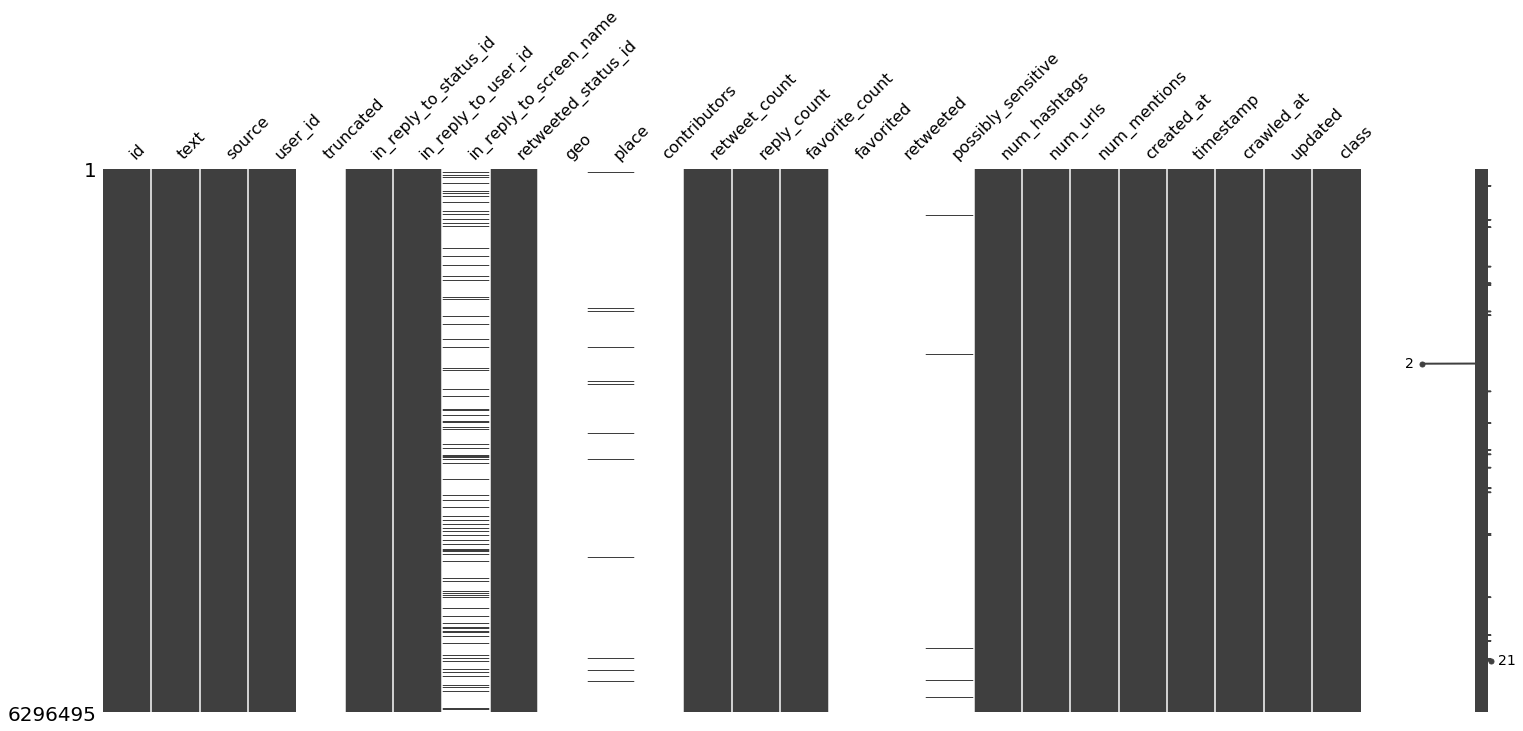

In [25]:
msno.matrix(tweets)

As shown in the matrix, many columns such as truncated, geo, contributors, etc. appear to be missing all datapoints. The data doesn't appear to be missing at random since there is a repetitive pattern between those columns. 

We will drop columns missing more than 90% of data points and in_reply_to_screen_name since that isn't our focus. Then, we will drop the remaining rows with missing values since that is only a small percentage of the dataset.

In [26]:
# Get columns with >= 80% missing
missing_df = missing_values_table(tweets)
missing_columns = list(missing_df[missing_df['% of Total Values'] >= 80].index)
print('We will drop %d columns.' % len(missing_columns))
print('Drop columns: ', missing_columns)

Your selected dataframe has 26 columns.
There are 24 columns that have missing values.
We will drop 8 columns.
Drop columns:  ['truncated', 'geo', 'contributors', 'favorited', 'retweeted', 'possibly_sensitive', 'place', 'in_reply_to_screen_name']


In [27]:
tweets.drop(labels=['truncated', 'geo', 'contributors', 'favorited', 'retweeted', 'possibly_sensitive', 'place','in_reply_to_screen_name'], axis=1, inplace=True)

In [28]:
# Drop all rows that have any NaN values
tweets = tweets.dropna()
tweets = tweets.reset_index(drop=True)

In [29]:
missing_values_table(tweets)

Your selected dataframe has 18 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


Next, we'll take a look at the users table. 

In [30]:
missing_values_table(users)

Your selected dataframe has 41 columns.
There are 19 columns that have missing values.


,Missing Values,% of Total Values
following,8386,100.0
contributors_enabled,8386,100.0
follow_request_sent,8386,100.0
notifications,8386,100.0
is_translator,8385,100.0
verified,8375,99.9
default_profile_image,8326,99.3
protected,8308,99.1
default_profile,7016,83.7
url,6835,81.5


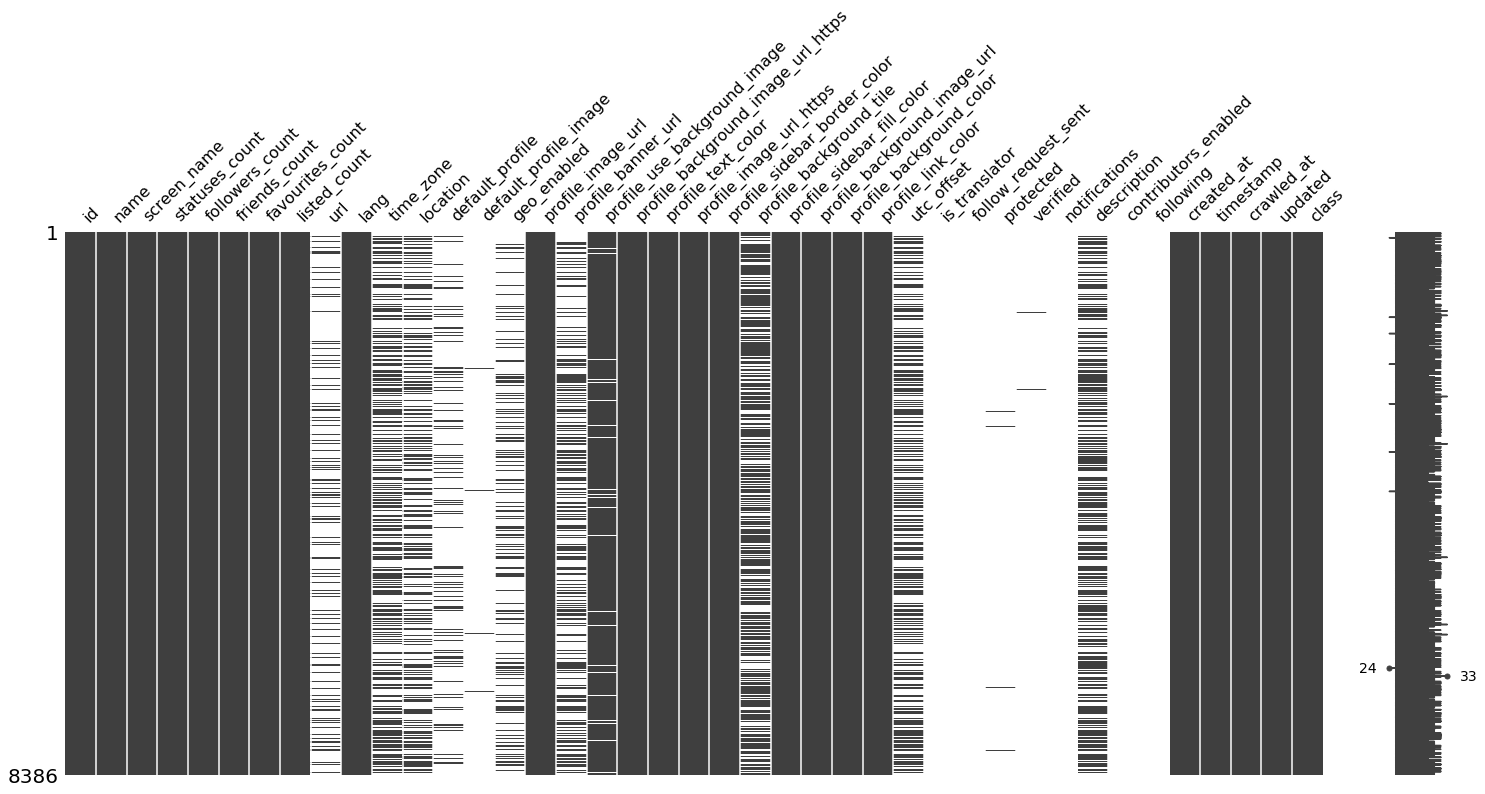

In [31]:
msno.matrix(users)

In [32]:
# Get columns with >= 30% missing
missing_df = missing_values_table(users)
missing_columns = list(missing_df[missing_df['% of Total Values'] >= 30].index)
print('We will drop %d columns.' % len(missing_columns))
print('Drop columns: ', missing_columns)

Your selected dataframe has 41 columns.
There are 19 columns that have missing values.
We will drop 17 columns.
Drop columns:  ['following', 'contributors_enabled', 'follow_request_sent', 'notifications', 'is_translator', 'verified', 'default_profile_image', 'protected', 'default_profile', 'url', 'geo_enabled', 'location', 'profile_banner_url', 'time_zone', 'utc_offset', 'description', 'profile_background_tile']


In [33]:
users.drop(labels=['following', 'contributors_enabled', 'follow_request_sent', 'notifications', 'is_translator', 'verified', 'default_profile_image', 'protected', 'default_profile', 'url', 'geo_enabled', 'location', 'profile_banner_url', 'time_zone', 'utc_offset', 'description', 'profile_background_tile'], axis=1, inplace=True)

In [34]:
# Drop all rows that have any NaN values
users = users.dropna()
users = users.reset_index(drop=True)

In [35]:
missing_values_table(users)

Your selected dataframe has 24 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


## Creating Time Series 

Time series data is used when we want to analyze or explore variation over time. This is useful when exploring Twitter text data if we want to track the prevalence of a word or set of words.

Let's convert timestamp into time datatype. 

In [51]:
# Print created_at to see the original format of datetime in Twitter data
print(tweets['created_at'].head())

0    Fri Apr 17 19:10:54 +0000 2015
1    Wed Sep 10 22:28:10 +0000 2014
2    Mon Oct 27 11:49:51 +0000 2014
3    Wed Nov 20 07:32:08 +0000 2013
4    Mon Sep 08 18:12:19 +0000 2014
Name: created_at, dtype: object


In [52]:
# Convert the created_at column to np.datetime object
tweets['timestamp'] = pd.to_datetime(tweets['timestamp'])
tweets['created_at'] = pd.to_datetime(tweets['created_at'])

In [53]:
# Print created_at to see new format
print(tweets['created_at'].head())

0   2015-04-17 19:10:54+00:00
1   2014-09-10 22:28:10+00:00
2   2014-10-27 11:49:51+00:00
3   2013-11-20 07:32:08+00:00
4   2014-09-08 18:12:19+00:00
Name: created_at, dtype: datetime64[ns, UTC]


In [54]:
# Set the index of df to created_at
tweets = tweets.set_index('created_at')

Now, let's do the same for the users table.

In [55]:
# Convert the created_at column to np.datetime object
users['timestamp'] = pd.to_datetime(users['timestamp'])
users['created_at'] = pd.to_datetime(users['created_at'])

In [56]:
# Print created_at to see new format
print(users['created_at'].head())

0   2012-03-11 06:59:04+00:00
1   2010-12-03 00:18:40+00:00
2   2014-03-10 03:06:50+00:00
3   2015-03-10 05:32:56+00:00
4   2013-05-08 15:02:48+00:00
Name: created_at, dtype: datetime64[ns, UTC]


In [57]:
# Set the index of df to created_at
users = users.set_index('created_at')

In [58]:
# Save clean data into CSV
tweets.to_csv('/Users/tsawaengsri/Desktop/Data Science Courses/Datasets/cresci-2017.csv/datasets_full.csv/clean_tweets', header=True, index=False)
users.to_csv('/Users/tsawaengsri/Desktop/Data Science Courses/Datasets/cresci-2017.csv/datasets_full.csv/clean_users', header=True, index=False)